### Starting model

In [1]:
from modeling.compute import Var
from modeling.gen3.nesting import Model, adda, addeq,addineq, addobj, setsolvefor, merge, OPT

In [2]:
model = Model()
m = model.root
Pbus = Var('P_{bus}')
A = Var('A', 0.5)
Pcomms = adda(m, 'P_{comms}', 483.3*A-Pbus)
adda(m, Pbus, 10*abs(Pcomms)**0.5)
h = Var('h', 400e3)
D = Var('D', 0.1)
R = adda(m, 'R', Pcomms*D**2/h**2*1e18/(8e6))
C = adda(m, 'C', 2.5*D**2+12*(A+1)+0.1*Pbus)

### Reduce size of problem through condensation strategy

In [3]:
formulation = model.generate_formulation()

In [4]:
from graph.operators import reformulate
from graph.matrixview import render_incidence

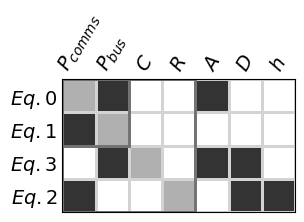

In [7]:
_,new_tree = reformulate(*formulation, root_solver_name=1)
formulation_scc = formulation[0], new_tree
render_incidence(*formulation_scc, rawvarname=True, figsize=((3,3)), rotation=60, hideticks=True, patchwidth=2, fontsize=14);

### Transform components based on new formulation graph

In [8]:
from modeling.gen2.transformations import transform_components

In [60]:
edges = formulation[0]
new_edges = formulation_scc[0]
new_comps = transform_components(edges, new_edges, model.components, model.idmapping)

### Generate optimization problem

In [61]:
addobj(m, C)
addeq(m, -R+1)
setsolvefor(m, [D,A], {D:[0.5,10], A:[0.04,1]}) # we pick only optimize over a subset of the input variables 

In [62]:
# we need to merge the reformulation with the added information
formulation_scc_opt = merge(model.generate_formulation(), *formulation_scc, copysolvers=False)

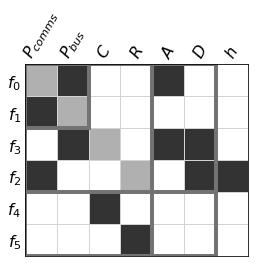

In [63]:
render_incidence(*formulation_scc_opt, rawvarname=True, figsize=((4,4)), rotation=60, hideticks=True, patchwidth=4);

# Generate workflow

In [64]:
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
idmapping = model.idmapping
nodetyperepr = model.nametyperepr
components = model.components+new_comps

In [65]:
solvers_options[1] = {'type': OPT, 'optimizer': 'SLSQP'}
solvers_options[2] = {'solver': 'N', 'maxiter':20}

### Workflow generation

In [66]:
from datastructures.workflow import order_from_tree

In [67]:
edges, tree = formulation_scc_opt
sequence = order_from_tree(tree[0], tree[1], edges[1])

In [68]:
sequence

[(SOLVER, 1, None),
 (SOLVER, 2, 1),
 (COMP, 0, 2),
 (COMP, 1, 2),
 (COMP, 3, 1),
 (COMP, 2, 1),
 (ENDCOMP, [4, 5], 1)]

### Solver Options
Populate the solvers with default values if not set, based on graph formulation

In [69]:
from datastructures.workflow import default_solver_options

In [70]:
solvers_options = default_solver_options(tree, solvers_options)

In [71]:
solvers_options

{1: {'type': OPT, 'optimizer': 'SLSQP', 'designvars': ('D', 'A')},
 2: {'solver': 'N',
  'maxiter': 20,
  'type': SOLVE,
  'designvars': ('P_{comms}', 'P_{bus}')}}

### openMDAO specific workflow
Based on solver options generate openMDAO specific workflow

In [72]:
from datastructures.workflow import mdao_workflow

In [73]:
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [74]:
wf

[(OPT,
  1,
  None,
  {'optimizer': 'SLSQP', 'designvars': ('D', 'A')},
  {'D': [0.5, 10], 'A': [0.04, 1]}),
 (SOLVE,
  2,
  1,
  {'solver': 'N', 'maxiter': 20, 'designvars': ('P_{comms}', 'P_{bus}')},
  {}),
 (EXPL, 0, 2),
 (EXPL, 1, 2),
 (EXPL, 3, 1),
 (EXPL, 2, 1),
 (OBJ, 4, 1),
 (EQ, 5, 1)]

- OPT = specifies design variables to be declared in openMDAO
- SOLVE = groups with nonlinear solvers in openMDAO
- IMPL = implicit component in openMDAO
- EXPL = explicit component in openMDAO
- OBJ = objective function for optimization

### Detailed openMDAO workflow
This contains the actual functions, and the explicit gradients that will be given to openMDAO

In [75]:
from datastructures.workflow import get_f
from datastructures.graphutils import namefromsympy
from datastructures.workflow_mdao import mdao_workflow_with_args

In [76]:
lookup_f = get_f(components, edges)
namingfunc = namefromsympy(nodetyperepr)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [77]:
wfmdao

[(OPT,
  None,
  's1',
  ('D', 'A'),
  {'optimizer': 'SLSQP'},
  {'D': [0.5, 10], 'A': [0.04, 1]}),
 (SOLVE, 's1', 's2', {'solver': 'N', 'maxiter': 20}, {}),
 (EXPL,
  's2',
  'f0',
  ('A', 'P_bus'),
  ('P_comms',),
  <bound method Component.evaldict of (('A', 'P_bus'), 0, ('P_comms',), 'None')>,
  <bound method Component.graddict of (('A', 'P_bus'), 0, ('P_comms',), 'None')>),
 (EXPL,
  's2',
  'f1',
  ('P_comms',),
  ('P_bus',),
  <bound method Component.evaldict of (('P_comms',), 1, ('P_bus',), 'None')>,
  <bound method Component.graddict of (('P_comms',), 1, ('P_bus',), 'None')>),
 (EXPL,
  's1',
  'f3',
  ('A', 'D', 'P_bus'),
  ('C',),
  <bound method Component.evaldict of (('A', 'D', 'P_bus'), 3, ('C',), 'None')>,
  <bound method Component.graddict of (('A', 'D', 'P_bus'), 3, ('C',), 'None')>),
 (EXPL,
  's1',
  'f2',
  ('h', 'P_comms', 'D'),
  ('R',),
  <bound method Component.evaldict of (('h', 'P_comms', 'D'), 2, ('R',), 'None')>,
  <bound method Component.graddict of (('h', '

### Assemble the formulation in openMDAO

In [78]:
from datastructures.assembly import build_archi

In [91]:
prob, mdao_in, groups = build_archi(edges, tree, wfmdao, namingfunc, idmapping)

# Execute model without running optimization

In [92]:
components

[(('A', 'P_{bus}'), 0, ('P_{comms}',), '483.3*A - P_{bus}'),
 (('P_{comms}',), 1, ('P_{bus}',), '10*Abs(P_{comms})**0.5'),
 (('h', 'P_{comms}', 'D'), 2, ('R',), '125000000000.0*D**2*P_{comms}/h**2'),
 (('A', 'D', 'P_{bus}'), 3, ('C',), '12*A + 2.5*D**2 + 0.1*P_{bus} + 12'),
 (('C',), 4, (None,), 'C'),
 (('R',), 5, (None,), '1 - R')]

In [93]:
components[0].graddict({'A':10, 'P_{bus}':10})

{('P_{comms}', 'A'): DeviceArray(483.3, dtype=float64),
 ('P_{comms}', 'P_{bus}'): DeviceArray(-1., dtype=float64)}

In [94]:
components[2].graddict({'h':h.varval, 'P_{comms}':10, 'D':10})

{('R', 'h'): DeviceArray(-0.00390625, dtype=float64),
 ('R', 'P_{comms}'): DeviceArray(78.125, dtype=float64),
 ('R', 'D'): DeviceArray(156.25, dtype=float64)}

In [95]:
components[3].graddict({'D':10, 'P_{bus}':10, 'A':10})

{('C', 'A'): DeviceArray(12., dtype=float64),
 ('C', 'D'): DeviceArray(50., dtype=float64),
 ('C', 'P_{bus}'): DeviceArray(0.1, dtype=float64)}

In [117]:
prob.set_val('D', 0.67)
prob.set_val('A', 0.1)
prob.run_model()


==
s2
==
NL: Newton Converged in 4 iterations


### Display results

In [115]:
from datastructures.postprocess import print_outputs
print_outputs(model, prob, namingfunc, rounding=3)

$$P_{comms}$$,12.697,
$$P_{bus}$$,35.633,
$$R$$,4.453,
$$C$$,17.886,


# Optimize model

In [116]:
prob.run_driver();


==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 0 iterations

==
s2
==
NL: Newton Converged in 5 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 4 iterations

==
s2
==
NL: Newton Converged in 2 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 3 iterations

==
s2
==
NL: Newton Converged in 2 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [15.30093085]
            Iterations: 8
            Function evaluations: 9
            Gradient evaluations: 7
Optimization Complete
-----------------------------------
